## 1. Install Required Libraries


In [1]:
# Install all required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn nltk joblib


## 2. Import Libraries


In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)

# Model saving
import joblib
import pickle
import time

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


All libraries imported successfully!


## 3. Load the Dataset


In [ ]:


from google.colab import drive
drive.mount('/content/drive')


filename = '/content/cleaned_df.csv'

print(f"Using file from Google Drive: {filename}")


Mounted at /content/drive
Using file from Google Drive: /content/cleaned_df.csv


In [ ]:


# Load the dataset
df = pd.read_csv(filename)

# Display basic info
print("="*60)
print("DATASET LOADED SUCCESSFULLY")
print("="*60)
print(f"\nShape: {df.shape[0]} reviews, {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 3 rows:")
df.head(3)


DATASET LOADED SUCCESSFULLY

Shape: 20491 reviews, 3 columns

Columns: ['Review', 'Rating', 'Length']

First 3 rows:


,Review,Rating,Length
0,nice hotel expensive park get good deal stay h...,Good,512
1,ok nothing special charge diamond member hilto...,Bad,1538
2,nice room 4 experience hotel monaco seattle go...,Netral,1325


## 4. Data Preprocessing


In [5]:
# Fix the typo in 'Netral' to 'Neutral'
df['Rating'] = df['Rating'].replace('Netral', 'Neutral')

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Remove rows with missing reviews
df = df.dropna(subset=['Review'])

# Display sentiment distribution
print("\nSentiment Distribution:")
print(df['Rating'].value_counts())

# Check if any class has too few samples
min_samples = df['Rating'].value_counts().min()
print(f"\nMinimum samples in any class: {min_samples}")

# If Neutral class has very few samples, we can either:
# Option 1: Remove classes with less than 10 samples
# Option 2: Keep only Good and Bad (binary classification)

if min_samples < 10:
    print("\n Some classes have too few samples. Filtering to classes with >= 10 samples...")
    valid_classes = df['Rating'].value_counts()[df['Rating'].value_counts() >= 10].index
    df = df[df['Rating'].isin(valid_classes)]
    print(f"\nUpdated Sentiment Distribution:")
    print(df['Rating'].value_counts())

print(f"\nTotal reviews: {len(df)}")


Missing values:
Review    0
Rating    0
Length    0
dtype: int64

Sentiment Distribution:
Rating
Good       15093
Bad         3214
Neutral     2184
Name: count, dtype: int64

Minimum samples in any class: 2184

Total reviews: 20491


In [6]:
# Prepare features and target
X = df['Review'].values
y = df['Rating'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label Encoding Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label} -> {i}")

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")


Label Encoding Mapping:
  Bad -> 0
  Good -> 1
  Neutral -> 2

Features shape: (20491,)
Target shape: (20491,)


## 5. Feature Extraction (TF-IDF Vectorization)


In [7]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,        # Limit to top 5000 features
    min_df=2,                  # Ignore terms that appear in less than 2 documents
    max_df=0.95,               # Ignore terms that appear in more than 95% of documents
    ngram_range=(1, 2),        # Use unigrams and bigrams
    stop_words='english'       # Remove English stop words
)

# Fit and transform the reviews
X_tfidf = tfidf_vectorizer.fit_transform(X)

print("TF-IDF Vectorization Complete!")
print(f"Feature matrix shape: {X_tfidf.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")


TF-IDF Vectorization Complete!
Feature matrix shape: (20491, 5000)
Number of features: 5000


## 6. Train-Test Split


In [8]:
# Check class distribution before splitting
print("Class distribution before split:")
unique, counts = np.unique(y_encoded, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.classes_[u]}: {c}")

# Determine if we can use stratified split (need at least 2 samples per class)
min_class_count = min(counts)
use_stratify = min_class_count >= 2

# Split data into training (80%) and testing (20%) sets
if use_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded  # Maintain class distribution
    )
    print("\n✓ Using stratified split (maintains class proportions)")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y_encoded,
        test_size=0.2,
        random_state=42
    )
    print("\n Using regular split (some classes have too few samples for stratification)")

print("\nTrain-Test Split Complete!")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Check class distribution in train and test sets
print("\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.classes_[u]}: {c} ({c/len(y_train)*100:.1f}%)")

print("\nClass distribution in testing set:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.classes_[u]}: {c} ({c/len(y_test)*100:.1f}%)")


Class distribution before split:
  Bad: 3214
  Good: 15093
  Neutral: 2184

✓ Using stratified split (maintains class proportions)

Train-Test Split Complete!
Training set size: 16392 samples
Testing set size: 4099 samples

Class distribution in training set:
  Bad: 2571 (15.7%)
  Good: 12074 (73.7%)
  Neutral: 1747 (10.7%)

Class distribution in testing set:
  Bad: 643 (15.7%)
  Good: 3019 (73.7%)
  Neutral: 437 (10.7%)


---
## 7. Model Training
---

We will train 4 machine learning models:
1. **Logistic Regression**
2. **Support Vector Machine (SVM)**
3. **Naïve Bayes**
4. **Random Forest**


In [9]:
# Dictionary to store all models and their results
models = {}
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Training Time (s)': []
}

def train_and_evaluate(model, model_name, X_train, X_test, y_train, y_test):
    """Train a model and evaluate its performance"""
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print('='*60)

    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)
    results['Training Time (s)'].append(training_time)

    # Store model
    models[model_name] = model

    # Print results
    print(f"\nResults for {model_name}:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Training Time: {training_time:.2f} seconds")

    return model, y_pred


### 7.1 Logistic Regression


In [10]:
# Initialize and train Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=1.0,  # Regularization parameter
    solver='lbfgs',
    multi_class='multinomial'
)

lr_model, lr_pred = train_and_evaluate(
    lr_model, 'Logistic Regression',
    X_train, X_test, y_train, y_test
)

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, lr_pred, target_names=label_encoder.classes_))



Training Logistic Regression...

Results for Logistic Regression:
  Accuracy:  0.8578 (85.78%)
  Precision: 0.8319
  Recall:    0.8578
  F1-Score:  0.8348
  Training Time: 2.68 seconds

Detailed Classification Report:
              precision    recall  f1-score   support

         Bad       0.82      0.75      0.78       643
        Good       0.88      0.98      0.93      3019
     Neutral       0.51      0.19      0.27       437

    accuracy                           0.86      4099
   macro avg       0.74      0.64      0.66      4099
weighted avg       0.83      0.86      0.83      4099



### 7.2 Support Vector Machine (SVM)


In [11]:
# Initialize and train SVM
svm_model = SVC(
    kernel='linear',  # Linear kernel for text classification
    C=1.0,
    random_state=42,
    probability=True  # Enable probability estimates
)

svm_model, svm_pred = train_and_evaluate(
    svm_model, 'Support Vector Machine (SVM)',
    X_train, X_test, y_train, y_test
)

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, svm_pred, target_names=label_encoder.classes_))



Training Support Vector Machine (SVM)...

Results for Support Vector Machine (SVM):
  Accuracy:  0.8556 (85.56%)
  Precision: 0.8297
  Recall:    0.8556
  F1-Score:  0.8364
  Training Time: 500.04 seconds

Detailed Classification Report:
              precision    recall  f1-score   support

         Bad       0.78      0.77      0.77       643
        Good       0.89      0.97      0.93      3019
     Neutral       0.46      0.21      0.28       437

    accuracy                           0.86      4099
   macro avg       0.71      0.65      0.66      4099
weighted avg       0.83      0.86      0.84      4099



### 7.3 Naïve Bayes


In [12]:
# Initialize and train Naïve Bayes (Multinomial)
nb_model = MultinomialNB(
    alpha=1.0  # Laplace smoothing parameter
)

nb_model, nb_pred = train_and_evaluate(
    nb_model, 'Naïve Bayes',
    X_train, X_test, y_train, y_test
)

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, nb_pred, target_names=label_encoder.classes_))



Training Naïve Bayes...

Results for Naïve Bayes:
  Accuracy:  0.8302 (83.02%)
  Precision: 0.8468
  Recall:    0.8302
  F1-Score:  0.7800
  Training Time: 0.01 seconds

Detailed Classification Report:
              precision    recall  f1-score   support

         Bad       0.80      0.65      0.72       643
        Good       0.83      0.99      0.90      3019
     Neutral       1.00      0.00      0.01       437

    accuracy                           0.83      4099
   macro avg       0.88      0.55      0.54      4099
weighted avg       0.85      0.83      0.78      4099



### 7.4 Random Forest


In [13]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

rf_model, rf_pred = train_and_evaluate(
    rf_model, 'Random Forest',
    X_train, X_test, y_train, y_test
)

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, rf_pred, target_names=label_encoder.classes_))



Training Random Forest...

Results for Random Forest:
  Accuracy:  0.8158 (81.58%)
  Precision: 0.7702
  Recall:    0.8158
  F1-Score:  0.7608
  Training Time: 22.76 seconds

Detailed Classification Report:
              precision    recall  f1-score   support

         Bad       0.88      0.51      0.65       643
        Good       0.81      1.00      0.89      3019
     Neutral       0.33      0.00      0.00       437

    accuracy                           0.82      4099
   macro avg       0.68      0.50      0.52      4099
weighted avg       0.77      0.82      0.76      4099



---
## 8. Model Comparison
---


In [14]:
# Create results dataframe
results_df = pd.DataFrame(results)

# Format percentages
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")
results_df['Precision'] = results_df['Precision'].apply(lambda x: f"{x:.4f}")
results_df['Recall'] = results_df['Recall'].apply(lambda x: f"{x:.4f}")
results_df['F1-Score'] = results_df['F1-Score'].apply(lambda x: f"{x:.4f}")
results_df['Training Time (s)'] = results_df['Training Time (s)'].apply(lambda x: f"{x:.2f}")

print("="*80)
print("MODEL COMPARISON TABLE")
print("="*80)
print(results_df.to_string(index=False))


MODEL COMPARISON TABLE
                       Model        Accuracy Precision Recall F1-Score Training Time (s)
         Logistic Regression 0.8578 (85.78%)    0.8319 0.8578   0.8348              2.68
Support Vector Machine (SVM) 0.8556 (85.56%)    0.8297 0.8556   0.8364            500.04
                 Naïve Bayes 0.8302 (83.02%)    0.8468 0.8302   0.7800              0.01
               Random Forest 0.8158 (81.58%)    0.7702 0.8158   0.7608             22.76


In [15]:
# Create numeric results for visualization
results_numeric = pd.DataFrame({
    'Model': results['Model'],
    'Accuracy': [float(x) for x in results['Accuracy']],
    'Precision': [float(x) for x in results['Precision']],
    'Recall': [float(x) for x in results['Recall']],
    'F1-Score': [float(x) for x in results['F1-Score']],
    'Training Time (s)': [float(x) for x in results['Training Time (s)']]
})

# Display as a clean table
print("\n" + "="*80)
print("PERFORMANCE METRICS COMPARISON")
print("="*80)
results_numeric.round(4)



PERFORMANCE METRICS COMPARISON


,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s)
0,Logistic Regression,0.8578,0.8319,0.8578,0.8348,2.6815
1,Support Vector Machine (SVM),0.8556,0.8297,0.8556,0.8364,500.0430
2,Naïve Bayes,0.8302,0.8468,0.8302,0.7800,0.0106
3,Random Forest,0.8158,0.7702,0.8158,0.7608,22.7553


### 8.1 Performance Metrics Visualization


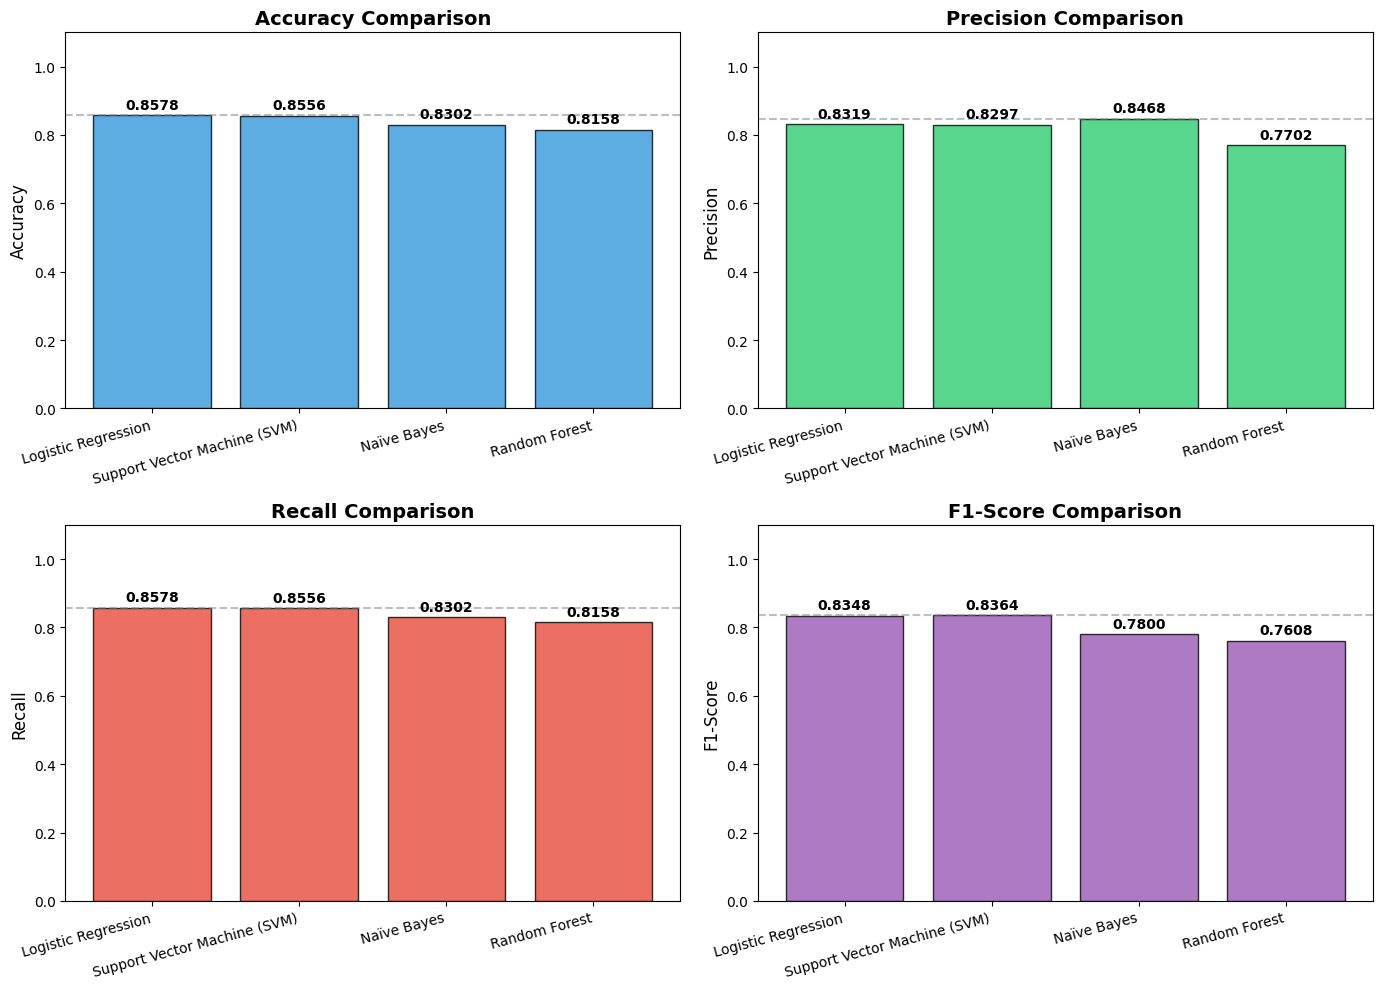


✓ Model comparison chart saved as 'model_comparison_metrics.png'


In [16]:
# Performance comparison bar chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for ax, metric, color in zip(axes.flatten(), metrics, colors):
    values = results_numeric[metric].values
    bars = ax.bar(results_numeric['Model'], values, color=color, edgecolor='black', alpha=0.8)

    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.set_xticklabels(results_numeric['Model'], rotation=15, ha='right')
    ax.axhline(y=max(values), color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Model comparison chart saved as 'model_comparison_metrics.png'")


### 8.2 Combined Metrics Comparison


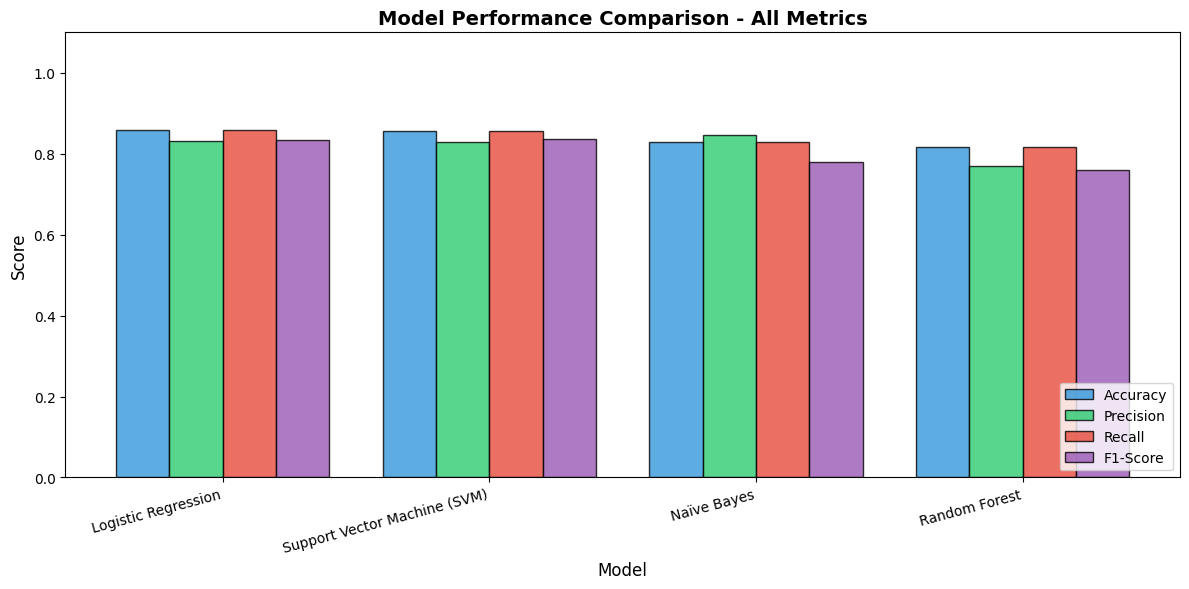


✓ Grouped comparison chart saved as 'model_comparison_grouped.png'


In [17]:
# Grouped bar chart for all metrics
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_numeric['Model']))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    bars = ax.bar(x + i*width, results_numeric[metric], width,
                  label=metric, color=color, edgecolor='black', alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison - All Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(results_numeric['Model'], rotation=15, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('model_comparison_grouped.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Grouped comparison chart saved as 'model_comparison_grouped.png'")


### 8.3 Confusion Matrices


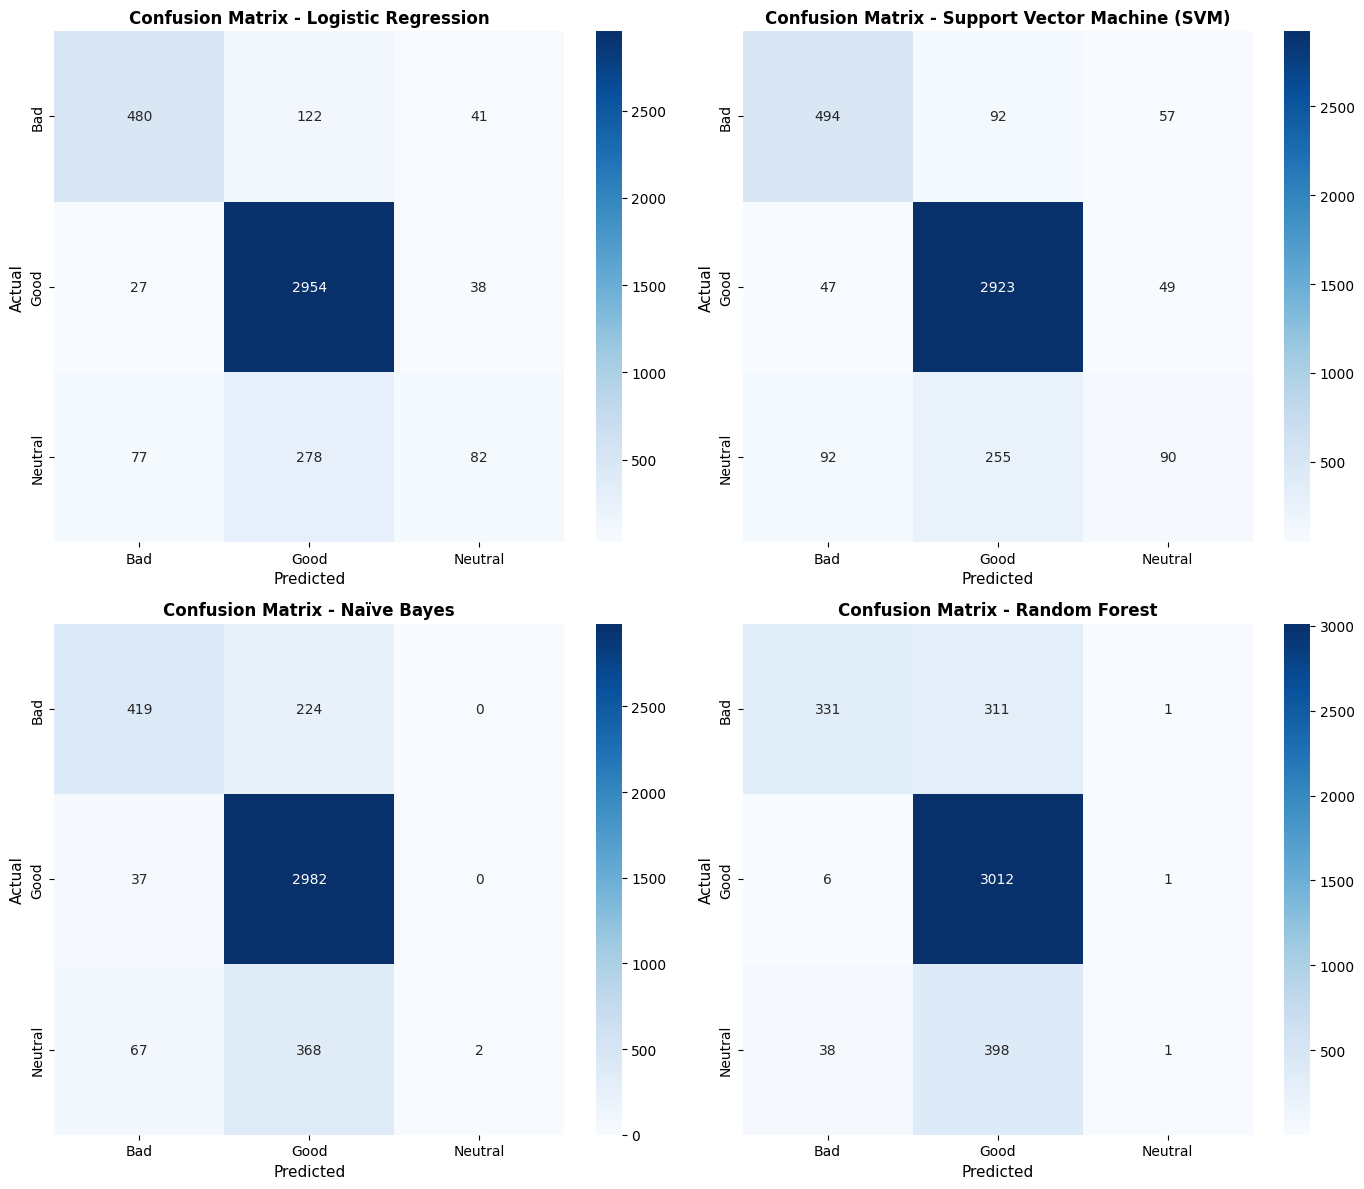


✓ Confusion matrices saved as 'confusion_matrices.png'


In [18]:
# Confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

predictions = {
    'Logistic Regression': lr_pred,
    'Support Vector Machine (SVM)': svm_pred,
    'Naïve Bayes': nb_pred,
    'Random Forest': rf_pred
}

for ax, (model_name, y_pred) in zip(axes.flatten(), predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices saved as 'confusion_matrices.png'")


### 8.4 Training Time Comparison


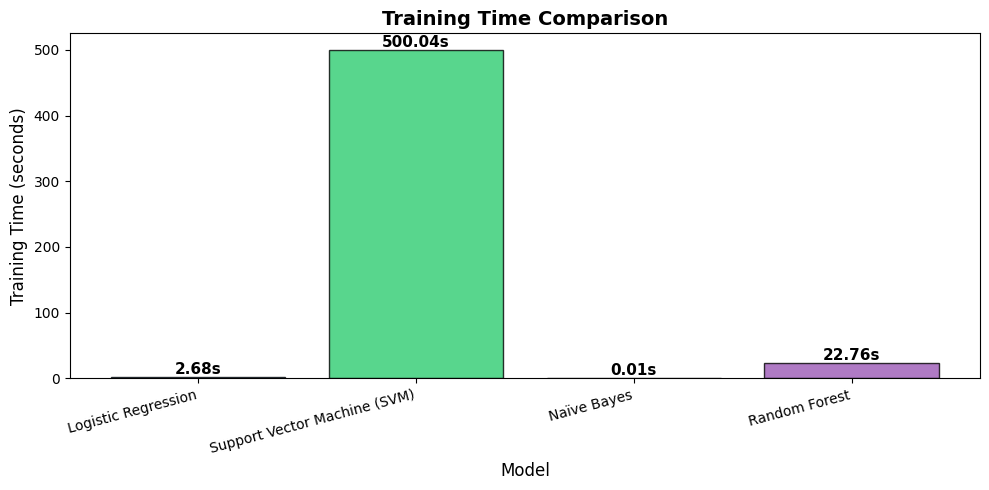


✓ Training time comparison saved as 'training_time_comparison.png'


In [19]:
# Training time comparison
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(results_numeric['Model'], results_numeric['Training Time (s)'],
              color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'],
              edgecolor='black', alpha=0.8)

# Add value labels
for bar, val in zip(bars, results_numeric['Training Time (s)']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Training Time (seconds)', fontsize=12)
ax.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax.set_xticklabels(results_numeric['Model'], rotation=15, ha='right')

plt.tight_layout()
plt.savefig('training_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training time comparison saved as 'training_time_comparison.png'")


---
## 9. Feature Importance Analysis
---


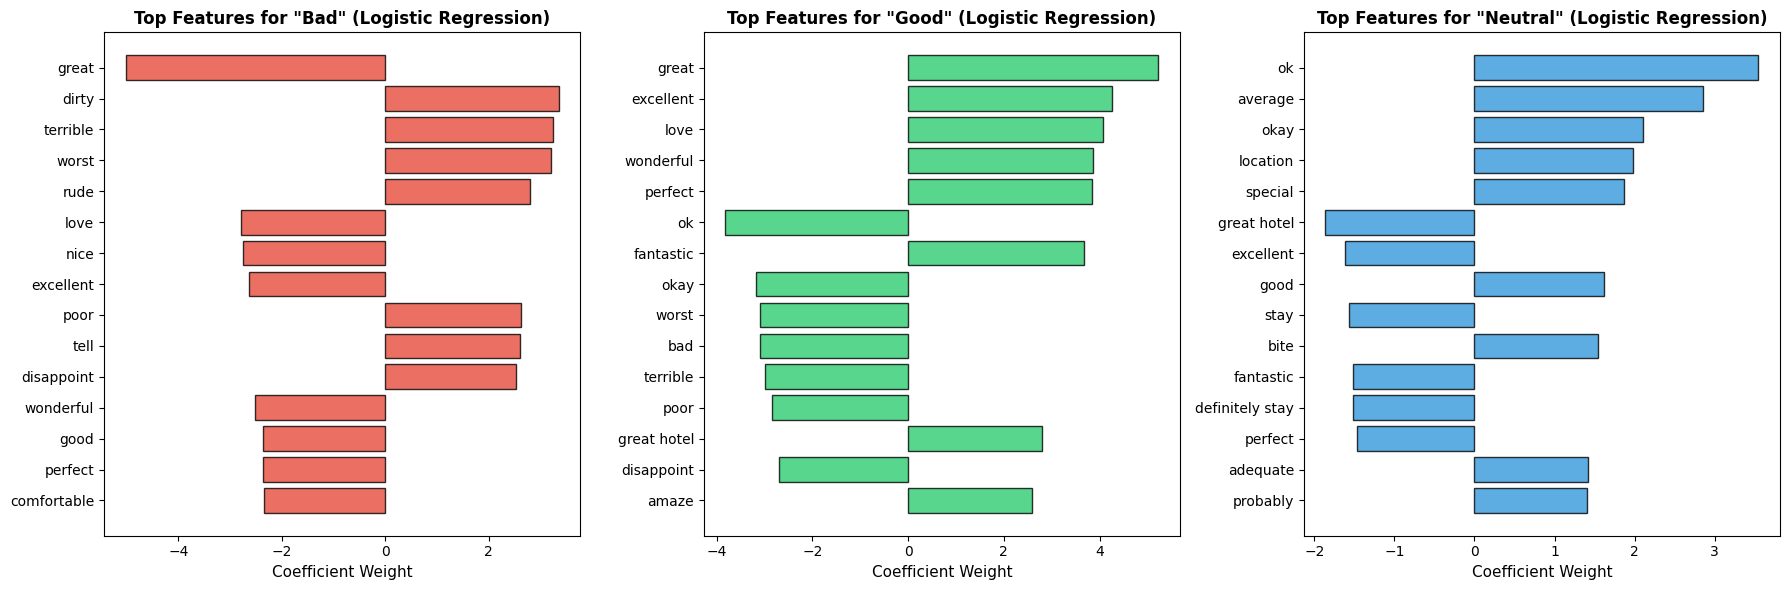


✓ Logistic Regression feature importance saved as 'feature_importance_lr.png'


In [20]:
# Feature importance from Logistic Regression
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get coefficients for each class
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

class_names = label_encoder.classes_
colors = ['#e74c3c', '#2ecc71', '#3498db']

for ax, class_idx, class_name, color in zip(axes, range(len(class_names)), class_names, colors):
    # Get coefficients for this class
    coef = lr_model.coef_[class_idx]

    # Get top 15 most important features
    top_indices = np.argsort(np.abs(coef))[-15:]
    top_features = feature_names[top_indices]
    top_weights = coef[top_indices]

    # Plot
    bars = ax.barh(range(len(top_features)), top_weights, color=color, edgecolor='black', alpha=0.8)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features)
    ax.set_xlabel('Coefficient Weight', fontsize=11)
    ax.set_title(f'Top Features for "{class_name}" (Logistic Regression)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance_lr.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Logistic Regression feature importance saved as 'feature_importance_lr.png'")


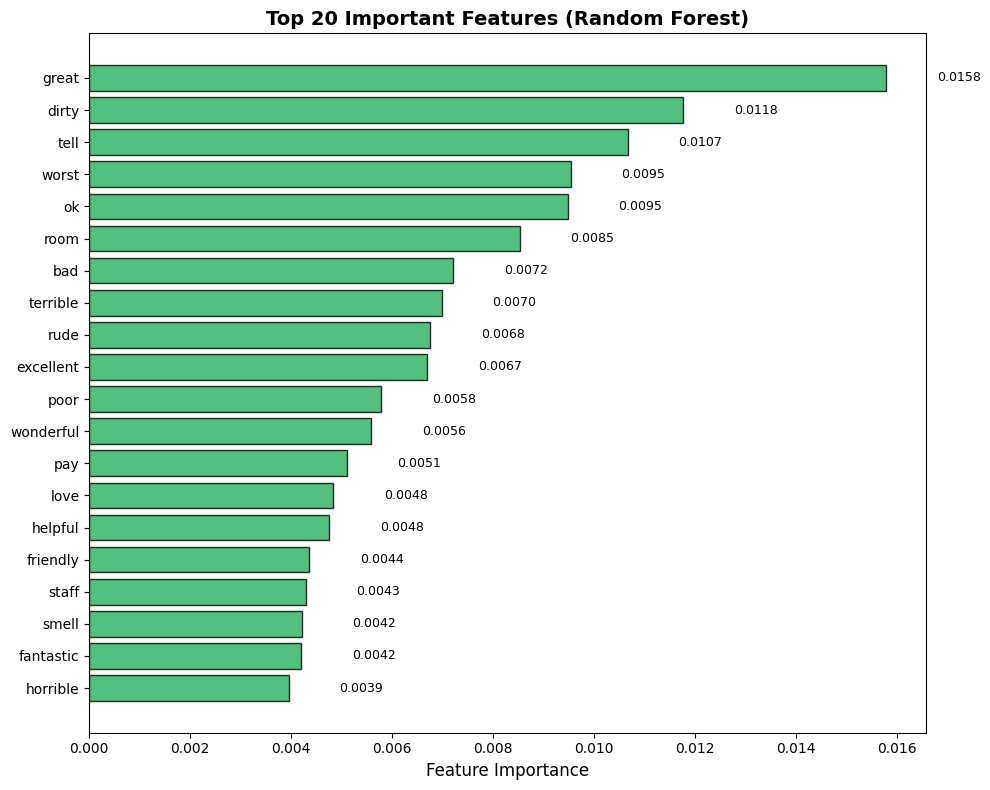


✓ Random Forest feature importance saved as 'feature_importance_rf.png'


In [21]:
# Feature importance from Random Forest
rf_importance = rf_model.feature_importances_

# Get top 20 most important features
top_n = 20
top_indices = np.argsort(rf_importance)[-top_n:]
top_features = feature_names[top_indices]
top_importances = rf_importance[top_indices]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.barh(range(len(top_features)), top_importances, color='#27ae60', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Top 20 Important Features (Random Forest)', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, top_importances):
    ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Random Forest feature importance saved as 'feature_importance_rf.png'")


---
## 10. Identify Best Model
---


In [22]:
# Identify the best performing model based on F1-Score
best_idx = results_numeric['F1-Score'].idxmax()
best_model_name = results_numeric.loc[best_idx, 'Model']
best_model = models[best_model_name]

print("="*60)
print("BEST PERFORMING MODEL")
print("="*60)
print(f"\n {best_model_name}")
print(f"\nPerformance Metrics:")
print(f"  • Accuracy:  {results_numeric.loc[best_idx, 'Accuracy']:.4f} ({results_numeric.loc[best_idx, 'Accuracy']*100:.2f}%)")
print(f"  • Precision: {results_numeric.loc[best_idx, 'Precision']:.4f}")
print(f"  • Recall:    {results_numeric.loc[best_idx, 'Recall']:.4f}")
print(f"  • F1-Score:  {results_numeric.loc[best_idx, 'F1-Score']:.4f}")
print(f"  • Training Time: {results_numeric.loc[best_idx, 'Training Time (s)']:.2f} seconds")


BEST PERFORMING MODEL

 Support Vector Machine (SVM)

Performance Metrics:
  • Accuracy:  0.8556 (85.56%)
  • Precision: 0.8297
  • Recall:    0.8556
  • F1-Score:  0.8364
  • Training Time: 500.04 seconds


---
## 12. Test the Model with Sample Reviews
---


In [25]:
def predict_sentiment(review_text, model, vectorizer, encoder):
    """Predict sentiment for a given review text"""
    # Vectorize the text
    text_vectorized = vectorizer.transform([review_text])

    # Predict
    prediction = model.predict(text_vectorized)[0]

    # Decode label
    sentiment = encoder.inverse_transform([prediction])[0]

    return sentiment

# Test with sample reviews
sample_reviews = [
    "Amazing hotel! Great location, friendly staff, and clean rooms. Highly recommend!",
    "Terrible experience. Room was dirty, staff was rude, and overpriced for what you get.",
    "The hotel was okay. Nothing special but nothing terrible either. Average experience."
]

print("="*60)
print("SAMPLE PREDICTIONS USING BEST MODEL")
print("="*60)

for i, review in enumerate(sample_reviews, 1):
    sentiment = predict_sentiment(review, best_model, tfidf_vectorizer, label_encoder)
    print(f"\nReview {i}: \"{review[:60]}...\"")
    print(f"Predicted Sentiment: {sentiment}")


SAMPLE PREDICTIONS USING BEST MODEL

Review 1: "Amazing hotel! Great location, friendly staff, and clean roo..."
Predicted Sentiment: Good

Review 2: "Terrible experience. Room was dirty, staff was rude, and ove..."
Predicted Sentiment: Bad

Review 3: "The hotel was okay. Nothing special but nothing terrible eit..."
Predicted Sentiment: Neutral
